# Personal VAD System - Interactive Demo

This notebook demonstrates the **PersonalVAD** system in action, including:
1. **Voice Enrollment** - Extract your voice embedding (d-vector)
2. **Feature Extraction** - Process audio into acoustic features
3. **Real-time Detection** - Detect when you (target speaker) are speaking
4. **Visualization** - See the system working in real-time

## System Overview

PersonalVAD is a voice activity detection system that can distinguish between:
- **NS (Non-Speech)** - Silence or non-speech audio
- **NTSS (Non-Target Speaker Speech)** - Someone else speaking
- **TSS (Target Speaker Speech)** - YOU speaking!

The system uses:
- **Mel-filterbank features** (40 coefficients)
- **Speaker embeddings (d-vectors)** from Resemblyzer
- **Cosine similarity scoring** between frame embeddings and target speaker
- **LSTM neural network** for temporal modeling

## Step 1: Import Required Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import librosa
import sounddevice as sd
import soundfile as sf
from pathlib import Path
from IPython.display import Audio, display, clear_output
import ipywidgets as widgets
from scipy.signal import medfilt

# Import PersonalVAD modules
from personal_vad import PersonalVAD
from resemblyzer import VoiceEncoder, preprocess_wav
from resemblyzer_mod import VoiceEncoderMod

print("✓ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ All libraries imported successfully!
PyTorch version: 1.13.1+cu117
CUDA available: True


## Step 2: Load Pre-trained PersonalVAD Model

Select one of the trained models. The recommended model is **vad_set_linear_score1_10ep.pt** (best performance).

In [2]:
# Model configuration
MODEL_NAME = 'vad_set_linear_score1_10ep.pt'  # Change this to try different models
MODEL_DIR = '../data/eval_dir/models/'
MODEL_PATH = MODEL_DIR + MODEL_NAME

# Parse model architecture from name
def parse_model_config(model_name):
    """Determine model configuration from model filename."""
    if 'set' in model_name:
        arch = 'set'
        input_dim = 297  # 40 fbanks + 256 d-vector + 1 score
    elif 'st' in model_name:
        arch = 'st'
        input_dim = 41  # 40 fbanks + 1 score
    elif 'et' in model_name:
        arch = 'et'
        input_dim = 296  # 40 fbanks + 256 d-vector
    else:
        raise ValueError(f"Unknown architecture in model name: {model_name}")
    
    linear = 'linear' in model_name
    use_fc = 'linear' in model_name or 'tanh' in model_name
    
    # Extract score type for SET/ST architectures
    score_type = 0
    if 'score0' in model_name:
        score_type = 0
    elif 'score1' in model_name:
        score_type = 1
    elif 'score2' in model_name:
        score_type = 2
    
    return arch, input_dim, use_fc, linear, score_type

# Parse configuration
arch, input_dim, use_fc, linear, score_type = parse_model_config(MODEL_NAME)

print(f"Loading model: {MODEL_NAME}")
print(f"  Architecture: {arch.upper()}")
print(f"  Input dimension: {input_dim}")
print(f"  Score type: {score_type}")
print(f"  Activation: {'Linear' if linear else 'Tanh'}")

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PersonalVAD(input_dim=input_dim, hidden_dim=64, num_layers=2, 
                    out_dim=3, use_fc=use_fc, linear=linear)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()

print(f"\n✓ Model loaded successfully on {device}!")

Loading model: vad_set_linear_score1_10ep.pt
  Architecture: SET
  Input dimension: 297
  Score type: 1
  Activation: Linear

✓ Model loaded successfully on cuda!

✓ Model loaded successfully on cuda!


## Step 3: Initialize Speaker Encoder

Load the Resemblyzer voice encoder for extracting speaker embeddings.

In [3]:
# Initialize voice encoders
print("Initializing speaker encoders...")

# For enrollment (utterance-level) - this loads pre-trained weights automatically
encoder = VoiceEncoder(device=device)

# For streaming (frame-level) - needs to copy weights from the main encoder
encoder_stream = VoiceEncoderMod()
encoder_stream.load_state_dict(encoder.state_dict())  # Copy pre-trained weights!
encoder_stream = encoder_stream.to(device)
encoder_stream.eval()

print("✓ Speaker encoders initialized!")
print(f"  Encoder device: {encoder.device}")
print(f"  Embedding dimension: 256")
print(f"  Pre-trained weights loaded: ✓")

Initializing speaker encoders...
Loaded the voice encoder model on cuda in 0.08 seconds.
Loaded the voice encoder model on cuda in 0.04 seconds.
✓ Speaker encoders initialized!
  Encoder device: cuda
  Embedding dimension: 256
  Pre-trained weights loaded: ✓
Loaded the voice encoder model on cuda in 0.04 seconds.
✓ Speaker encoders initialized!
  Encoder device: cuda
  Embedding dimension: 256
  Pre-trained weights loaded: ✓


## Step 4: Voice Enrollment - Record Your Voice

**Record 5-10 seconds of your voice** to create your speaker profile. 

Tips for good enrollment:
- Speak naturally for 5-10 seconds
- Read a sentence or talk about your day
- Avoid long pauses
- Use the same microphone as for testing

In [4]:
# Audio recording parameters
SAMPLE_RATE = 16000
ENROLLMENT_DURATION = 8  # seconds

def record_audio(duration, sample_rate=16000):
    """Record audio from microphone."""
    print(f"🎤 Recording for {duration} seconds...")
    print("   Speak naturally - introduce yourself or read a sentence!")
    audio = sd.rec(int(duration * sample_rate), 
                   samplerate=sample_rate, 
                   channels=1, 
                   dtype='float32')
    sd.wait()
    print("✓ Recording complete!")
    return audio.flatten()

# Record enrollment audio
print("=" * 70)
print("VOICE ENROLLMENT")
print("=" * 70)
enrollment_audio = record_audio(ENROLLMENT_DURATION, SAMPLE_RATE)

# Display audio for playback
print("\n📢 Playback your enrollment audio:")
display(Audio(enrollment_audio, rate=SAMPLE_RATE))

# Save enrollment audio
enrollment_path = Path('enrollment_audio.wav')
sf.write(enrollment_path, enrollment_audio, SAMPLE_RATE)
print(f"\n💾 Saved to: {enrollment_path}")

VOICE ENROLLMENT
🎤 Recording for 8 seconds...
   Speak naturally - introduce yourself or read a sentence!
✓ Recording complete!

📢 Playback your enrollment audio:
✓ Recording complete!

📢 Playback your enrollment audio:



💾 Saved to: enrollment_audio.wav


## Step 5: Extract Your Speaker Embedding (D-vector)

This creates a 256-dimensional vector that represents your voice characteristics.

Extracting speaker embedding...
✓ Speaker embedding extracted!
  Shape: (256,)
  Dtype: float32
  L2 norm: 1.0000
  First 5 values: [0.00546912 0.         0.22990607 0.         0.        ]
✓ Speaker embedding extracted!
  Shape: (256,)
  Dtype: float32
  L2 norm: 1.0000
  First 5 values: [0.00546912 0.         0.22990607 0.         0.        ]


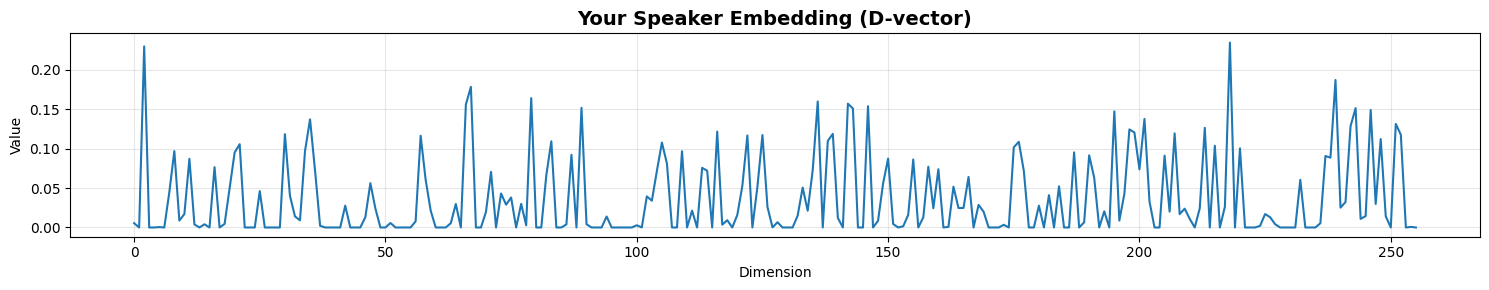


✅ Enrollment complete! Your voice is now registered.
   (Audio was preprocessed: volume normalized, silence trimmed)


In [5]:
print("Extracting speaker embedding...")

# Ensure audio is float32
enrollment_audio = enrollment_audio.astype(np.float32)

# Preprocess audio using Resemblyzer's preprocessing (same as training)
# This normalizes volume, trims silence, and resamples if needed
preprocessed_audio = preprocess_wav(enrollment_audio)

# Extract d-vector using Resemblyzer's embed_speaker method
# Pass as a list (can average multiple utterances)
target_embedding = encoder.embed_speaker([preprocessed_audio])

print(f"✓ Speaker embedding extracted!")
print(f"  Shape: {target_embedding.shape}")
print(f"  Dtype: {target_embedding.dtype}")
print(f"  L2 norm: {np.linalg.norm(target_embedding):.4f}")
print(f"  First 5 values: {target_embedding[:5]}")

# Visualize embedding
plt.figure(figsize=(15, 3))
plt.plot(target_embedding)
plt.title('Your Speaker Embedding (D-vector)', fontsize=14, fontweight='bold')
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Enrollment complete! Your voice is now registered.")
print("   (Audio was preprocessed: volume normalized, silence trimmed)")

## Step 6: Feature Extraction Functions

Define functions to extract features and compute similarity scores.

In [6]:
def extract_features(audio, target_embedding, score_type=1):
    """
    Extract PersonalVAD features from real audio input (not from disk).
    Matches the training pipeline for ET/SET/ST architectures.
    
    CRITICAL: Feature order must match training!
    - ET:  [fbanks (40)] + [d-vector (256)]
    - SET: [fbanks (40)] + [scores (1)] + [d-vector (256)]  ← FIXED ORDER!
    - ST:  [fbanks (40)] + [scores (1)]
    """
    import numpy as np
    # Ensure audio is float32
    audio = audio.astype(np.float32)

    # Extract mel-filterbank features
    fbanks = librosa.feature.melspectrogram(
        y=audio, sr=SAMPLE_RATE, n_fft=400,
        hop_length=160, n_mels=40
    ).astype('float32').T[:-2]  # Remove last 2 frames for alignment

    log_fbanks = np.log10(fbanks + 1e-6).astype('float32')
    n_frames = log_fbanks.shape[0]

    # Extract frame-level embeddings for scoring
    with torch.no_grad():
        fbanks_tensor = torch.from_numpy(fbanks).unsqueeze(0).to(device).float()
        frame_embeddings, _ = encoder_stream.forward_stream(fbanks_tensor, None)
        frame_embeddings = frame_embeddings.cpu().numpy().squeeze()

    # Compute cosine similarity scores
    def cosine_similarity(a, b):
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

    scores_stream = np.array([cosine_similarity(target_embedding, emb)
                              for emb in frame_embeddings])

    # Compute partial embeddings for window-based scoring
    wav_slices, mel_slices = VoiceEncoder.compute_partial_slices(
        audio.size, rate=2.5, min_coverage=0.5
    )
    max_wave_length = wav_slices[-1].stop
    if max_wave_length >= audio.size:
        audio_padded = np.pad(audio, (0, max_wave_length - audio.size), "constant")
    else:
        audio_padded = audio

    mels = librosa.feature.melspectrogram(
        y=audio_padded, sr=SAMPLE_RATE, n_fft=400,
        hop_length=160, n_mels=40
    ).astype('float32').T

    fbanks_sliced = np.array([mels[s] for s in mel_slices])

    with torch.no_grad():
        embeds_slices = encoder.forward(torch.from_numpy(fbanks_sliced).to(device).float())
        embeds_slices = embeds_slices.cpu().numpy()

    scores_slices = np.array([cosine_similarity(target_embedding, emb)
                              for emb in embeds_slices])

    # Expand scores using different methods
    frame_step = int(np.round((SAMPLE_RATE / 2.5) / 160))

    # Method 1: Kronecker product (repeat each score)
    scores_kron = np.kron(scores_slices[0], np.ones(160, dtype='float32'))
    if scores_slices.size > 1:
        scores_kron = np.append(scores_kron,
                np.kron(scores_slices[1:], np.ones(frame_step, dtype='float32')))
    scores_kron = scores_kron[:n_frames]

    # Method 2: Linear interpolation
    scores_lin = np.kron(scores_slices[0], np.ones(160, dtype='float32'))
    for i, s in enumerate(scores_slices[1:]):
        scores_lin = np.append(scores_lin,
                np.linspace(scores_slices[i], s, frame_step, endpoint=False))
    scores_lin = scores_lin[:n_frames]

    # Stack all three score types
    scores_all = np.stack((scores_stream, scores_kron, scores_lin))

    # Select score based on score_type
    scores = scores_all[score_type, :].astype('float32')

    # Build feature vector based on architecture
    # CRITICAL: Order must match training exactly!
    if arch == 'et':
        # ET: fbanks + d-vector
        target_tiled = np.tile(target_embedding, (n_frames, 1)).astype('float32')
        features = np.concatenate([log_fbanks, target_tiled], axis=1)

    elif arch == 'st':
        # ST: fbanks + scores
        features = np.concatenate([log_fbanks, scores.reshape(-1, 1)], axis=1)

    elif arch == 'set':
        # SET: fbanks + scores + d-vector (CORRECTED ORDER!)
        # Training code does: x = hstack(fbanks, scores); x = hstack(x, embed)
        target_tiled = np.tile(target_embedding, (n_frames, 1)).astype('float32')
        features = np.concatenate([log_fbanks, scores.reshape(-1, 1), target_tiled], axis=1)

    # Ensure final features are float32
    features = features.astype('float32')

    return features, log_fbanks, scores

print("✓ Feature extraction functions defined!")
print("  ⚠️  CRITICAL FIX: SET feature order corrected to match training!")

✓ Feature extraction functions defined!
  ⚠️  CRITICAL FIX: SET feature order corrected to match training!


## Step 7: Test on Audio File

Test the system on an audio file. You can:
1. Record a new test audio
2. Use an existing audio file
3. Use your enrollment audio

In [7]:
# Option 1: Record new test audio
print("=" * 70)
print("TEST AUDIO RECORDING")
print("=" * 70)
print("\nRecord test audio with:")
print("  - Only you speaking")
print("  - Someone else speaking")
print("  - Mixed conversation")
print("  - Background noise")
print()

TEST_DURATION = 10  # seconds
test_audio = record_audio(TEST_DURATION, SAMPLE_RATE)

# Display test audio
print("\n📢 Playback test audio:")
display(Audio(test_audio, rate=SAMPLE_RATE))

# Save test audio
test_path = Path('test_audio.wav')
sf.write(test_path, test_audio, SAMPLE_RATE)
print(f"\n💾 Saved to: {test_path}")

TEST AUDIO RECORDING

Record test audio with:
  - Only you speaking
  - Someone else speaking
  - Mixed conversation
  - Background noise

🎤 Recording for 10 seconds...
   Speak naturally - introduce yourself or read a sentence!
✓ Recording complete!

📢 Playback test audio:
✓ Recording complete!

📢 Playback test audio:



💾 Saved to: test_audio.wav


In [ ]:
# Option 2: Load existing audio file (uncomment to use)
# test_audio, sr = librosa.load('path/to/your/audio.wav', sr=SAMPLE_RATE)
# print(f"Loaded audio: {len(test_audio)/SAMPLE_RATE:.2f} seconds")

## Step 8: Run PersonalVAD Detection

Process the test audio and detect target speaker speech.

In [8]:
print("Running PersonalVAD detection...\n")

# Ensure test audio is float32
test_audio = test_audio.astype(np.float32)

# Extract features
features, fbanks, scores = extract_features(test_audio, target_embedding, score_type)

print(f"✓ Features extracted:")
print(f"  Feature shape: {features.shape}")
print(f"  Feature dtype: {features.dtype}")
print(f"  Number of frames: {features.shape[0]}")
print(f"  Duration: {features.shape[0] * 0.01:.2f} seconds")
print(f"  Score range: [{scores.min():.3f}, {scores.max():.3f}]")
print(f"  Mean score: {scores.mean():.3f}")

# Run PersonalVAD model
with torch.no_grad():
    features_tensor = torch.from_numpy(features).unsqueeze(0).to(device).float()
    x_lens = [features.shape[0]]
    
    # Forward pass
    output, _ = model(features_tensor, x_lens, None)
    output = output.squeeze(0).cpu()
    
    # Apply softmax to get probabilities
    probabilities = torch.softmax(output, dim=1).numpy()
    
    # Get predicted classes
    predictions = torch.argmax(output, dim=1).numpy()

print(f"\n✓ Detection complete!")
print(f"  Output shape: {probabilities.shape}")
print(f"  Classes: 0=NS, 1=NTSS, 2=TSS")

# Compute statistics
class_names = ['Non-Speech (NS)', 'Non-Target Speaker (NTSS)', 'Target Speaker (TSS)']
for i, name in enumerate(class_names):
    percentage = (predictions == i).sum() / len(predictions) * 100
    print(f"  {name}: {percentage:.1f}%")

Running PersonalVAD detection...

✓ Features extracted:
  Feature shape: (999, 297)
  Feature dtype: float32
  Number of frames: 999
  Duration: 9.99 seconds
  Score range: [0.595, 0.862]
  Mean score: 0.701
✓ Features extracted:
  Feature shape: (999, 297)
  Feature dtype: float32
  Number of frames: 999
  Duration: 9.99 seconds
  Score range: [0.595, 0.862]
  Mean score: 0.701

✓ Detection complete!
  Output shape: (999, 3)
  Classes: 0=NS, 1=NTSS, 2=TSS
  Non-Speech (NS): 12.0%
  Non-Target Speaker (NTSS): 27.1%
  Target Speaker (TSS): 60.9%

✓ Detection complete!
  Output shape: (999, 3)
  Classes: 0=NS, 1=NTSS, 2=TSS
  Non-Speech (NS): 12.0%
  Non-Target Speaker (NTSS): 27.1%
  Target Speaker (TSS): 60.9%


## Step 8.5: Diagnostic - Check Similarity Scores

Let's verify if your enrollment embedding is being properly compared to test audio.

In [97]:
print("🔍 DIAGNOSTIC ANALYSIS")
print("=" * 70)

# 1. Check if enrollment and test embeddings are similar
print("\n1️⃣ Enrollment Audio Self-Similarity Check:")
print("   Testing if enrollment audio recognizes itself...")

# Extract features from enrollment audio
enroll_features, enroll_fbanks, enroll_scores = extract_features(enrollment_audio, target_embedding, score_type)

print(f"   Enrollment self-similarity scores:")
print(f"     Mean: {enroll_scores.mean():.4f}")
print(f"     Median: {np.median(enroll_scores):.4f}")
print(f"     Min: {enroll_scores.min():.4f}")
print(f"     Max: {enroll_scores.max():.4f}")

if enroll_scores.mean() < 0.7:
    print("   ⚠️  WARNING: Enrollment doesn't recognize itself well!")
    print("   This suggests an issue with embedding extraction.")
else:
    print("   ✓ Enrollment self-recognition looks good!")

# 2. Compare test audio scores
print(f"\n2️⃣ Test Audio Similarity Scores:")
print(f"   Mean: {scores.mean():.4f}")
print(f"   Median: {np.median(scores):.4f}")
print(f"   Min: {scores.min():.4f}")
print(f"   Max: {scores.max():.4f}")
print(f"   Frames with score > 0.5: {(scores > 0.5).sum()} / {len(scores)} ({(scores > 0.5).sum()/len(scores)*100:.1f}%)")

if scores.mean() < 0.3:
    print("   ⚠️  Very low similarity - test audio may not contain target speaker")
elif scores.mean() < 0.5:
    print("   ⚠️  Low similarity - model may need recalibration or different recording conditions")
else:
    print("   ✓ Good similarity scores!")

# 3. Check embedding similarity directly
print(f"\n3️⃣ Embedding Comparison:")
print(f"   Target embedding norm: {np.linalg.norm(target_embedding):.4f}")
print(f"   Target embedding mean: {target_embedding.mean():.4f}")
print(f"   Target embedding std: {target_embedding.std():.4f}")

# Extract a test embedding from test audio using preprocess_wav
test_preprocessed = preprocess_wav(test_audio)
test_embedding_direct = encoder.embed_speaker([test_preprocessed])

# Compute direct cosine similarity
direct_similarity = np.dot(target_embedding, test_embedding_direct) / (
    np.linalg.norm(target_embedding) * np.linalg.norm(test_embedding_direct)
)

print(f"   Direct enrollment ↔ test similarity: {direct_similarity:.4f}")

if direct_similarity < 0.5:
    print("   ⚠️  Low direct similarity - recordings may be from different speakers")
    print("   💡 Suggestions:")
    print("      - Re-record enrollment with same microphone/distance as test")
    print("      - Ensure both recordings have similar volume levels")
    print("      - Speak in the same style (not whispering vs shouting)")
elif direct_similarity < 0.7:
    print("   ⚠️  Moderate similarity - consider re-recording with better conditions")
else:
    print("   ✓ High similarity - embeddings match well!")

# 4. Check feature dimensions and values
print(f"\n4️⃣ Feature Inspection:")
print(f"   Enrollment features shape: {enroll_features.shape}")
print(f"   Expected input_dim: {input_dim}")
if enroll_features.shape[1] != input_dim:
    print(f"   ⚠️  MISMATCH: Features have {enroll_features.shape[1]} dims but model expects {input_dim}!")
else:
    print(f"   ✓ Feature dimensions match model input!")

# Check feature value ranges (using fbanks from Step 8)
print(f"   Log-fbanks range: [{fbanks.min():.3f}, {fbanks.max():.3f}]")
print(f"   Log-fbanks mean: {fbanks.mean():.3f}")
print(f"   Scores range: [{scores.min():.3f}, {scores.max():.3f}]")

# 5. Check model predictions on enrollment
print(f"\n5️⃣ Model Prediction on Enrollment Audio:")
with torch.no_grad():
    enroll_tensor = torch.from_numpy(enroll_features).unsqueeze(0).to(device).float()
    enroll_output, _ = model(enroll_tensor, [enroll_features.shape[0]], None)
    enroll_probs = torch.softmax(enroll_output.squeeze(0), dim=1).cpu().numpy()
    enroll_preds = torch.argmax(enroll_output.squeeze(0), dim=1).cpu().numpy()

tss_percentage = (enroll_preds == 2).sum() / len(enroll_preds) * 100
ns_percentage = (enroll_preds == 0).sum() / len(enroll_preds) * 100
ntss_percentage = (enroll_preds == 1).sum() / len(enroll_preds) * 100

print(f"   NS:   {ns_percentage:.1f}%")
print(f"   NTSS: {ntss_percentage:.1f}%")
print(f"   TSS:  {tss_percentage:.1f}%")

if tss_percentage < 50:
    print("   ⚠️  CRITICAL: Model doesn't recognize enrollment as target speaker!")
    print("   💡 This suggests:")
    print("      - Feature construction mismatch with training")
    print("      - Wrong score type selected")
    print("      - Model-data incompatibility")
    print(f"\n   💡 Current configuration:")
    print(f"      Model: {MODEL_NAME}")
    print(f"      Architecture: {arch}")
    print(f"      Score type: {score_type} (0=stream, 1=kron, 2=linear)")
else:
    print("   ✓ Model correctly identifies enrollment audio!")

print("\n" + "=" * 70)
print("📋 RECOMMENDATION:")

if enroll_features.shape[1] != input_dim:
    print("❌ CRITICAL: Feature dimension mismatch - check architecture selection")
elif enroll_scores.mean() < 0.7:
    print("❌ Issue with embedding extraction - check encoder initialization")
elif direct_similarity < 0.5:
    print("❌ Enrollment and test audio don't match - please re-record")
    print("   Use same microphone, distance, and speaking style")
elif tss_percentage < 50:
    print("❌ Model not recognizing target speaker")
    print("   💡 Possible solutions:")
    print("      1. Try different score types (0, 1, or 2)")
    print("      2. Check if model architecture matches (ET/ST/SET)")
    print("      3. Verify model was trained with d-vectors (not x-vectors/i-vectors)")
    print("      4. Try a different model from ../data/eval_dir/models/")
else:
    print("✅ System looks good - low TSS% may be correct (you may not be speaking much in test)")

print("=" * 70)

🔍 DIAGNOSTIC ANALYSIS

1️⃣ Enrollment Audio Self-Similarity Check:
   Testing if enrollment audio recognizes itself...
   Enrollment self-similarity scores:
     Mean: 0.7651
     Median: 0.8124
     Min: 0.6195
     Max: 0.9055
   ✓ Enrollment self-recognition looks good!

2️⃣ Test Audio Similarity Scores:
   Mean: 0.6681
   Median: 0.6964
   Min: 0.4478
   Max: 0.7962
   Frames with score > 0.5: 839 / 999 (84.0%)
   ✓ Good similarity scores!

3️⃣ Embedding Comparison:
   Target embedding norm: 1.0000
   Target embedding mean: 0.0388
   Target embedding std: 0.0490
   Direct enrollment ↔ test similarity: 0.8166
   ✓ High similarity - embeddings match well!

4️⃣ Feature Inspection:
   Enrollment features shape: (799, 297)
   Expected input_dim: 297
   ✓ Feature dimensions match model input!
   Log-fbanks range: [-6.000, 0.898]
   Log-fbanks mean: -4.401
   Scores range: [0.448, 0.796]

5️⃣ Model Prediction on Enrollment Audio:
   NS:   28.3%
   NTSS: 0.0%
   TSS:  71.7%
   ✓ Model corr

## Step 9: Visualize Results

Create comprehensive visualization of the detection results.

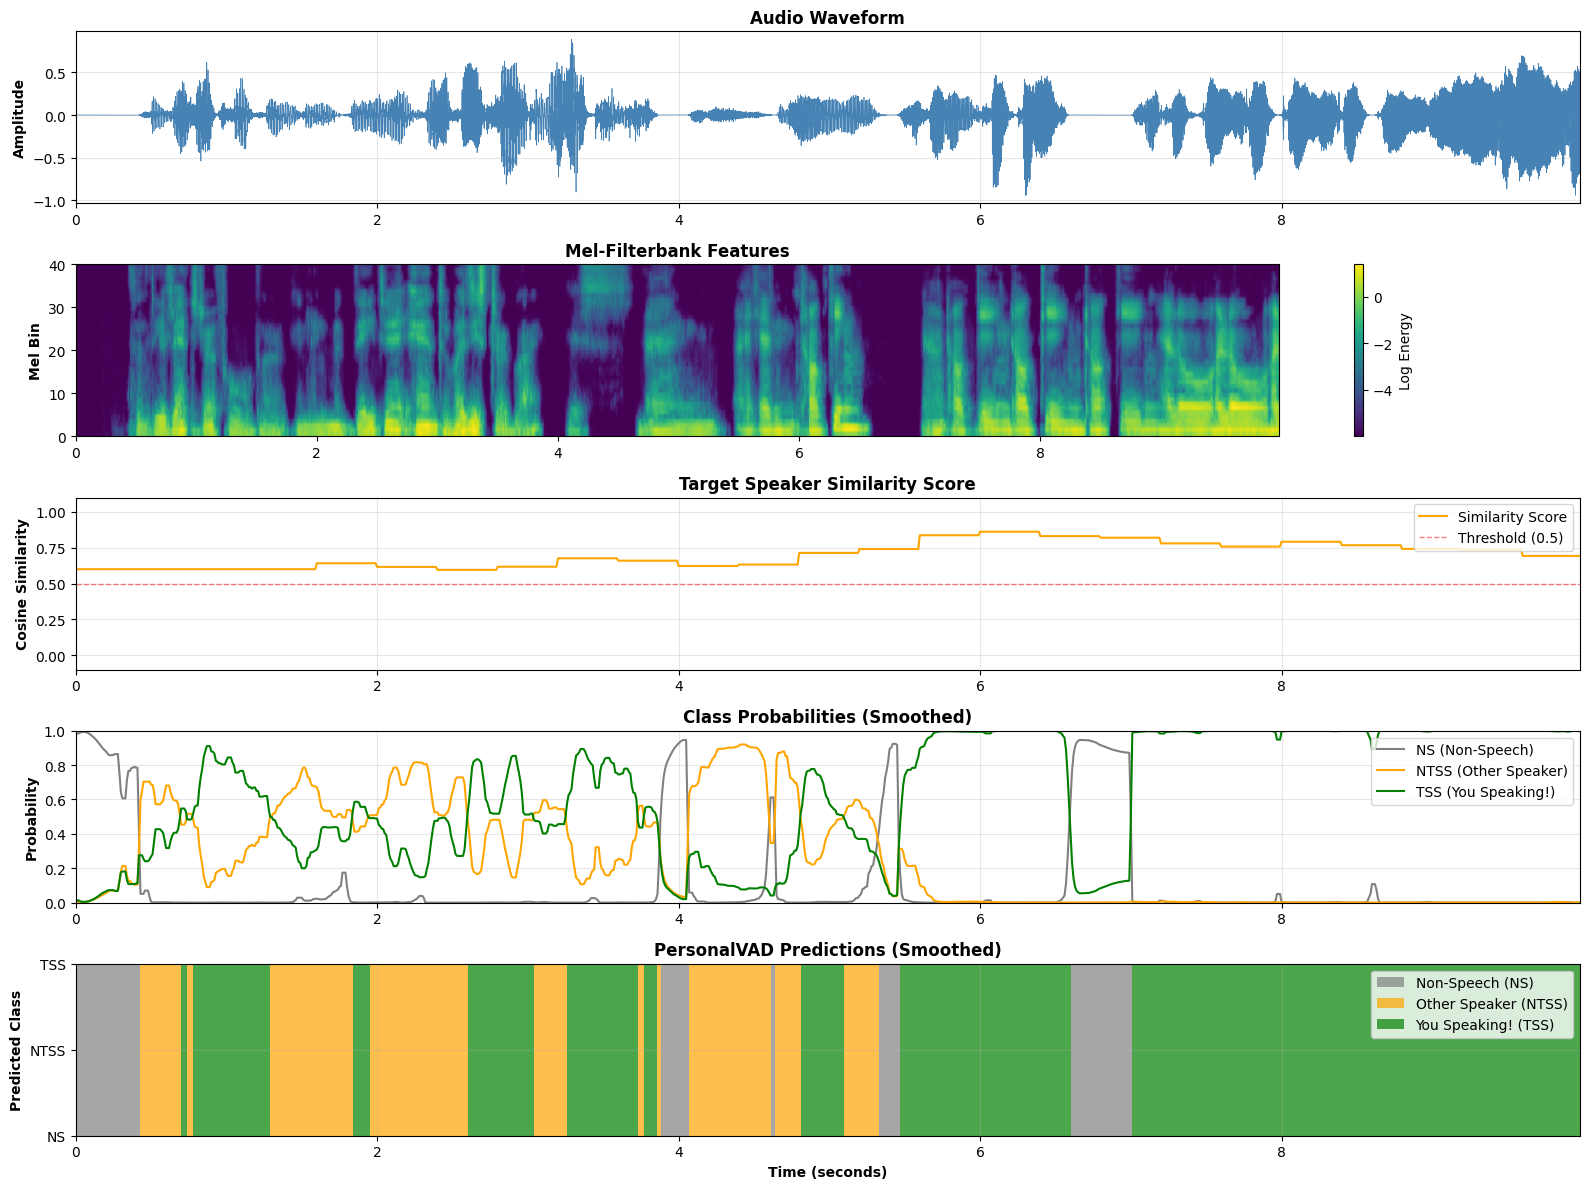


✓ Visualization saved as 'personal_vad_results.png'


In [9]:
# Apply median filtering for smoother predictions
predictions_smooth = medfilt(predictions, kernel_size=5)
probabilities_smooth = np.copy(probabilities)
for i in range(3):
    probabilities_smooth[:, i] = medfilt(probabilities[:, i], kernel_size=5)

# Time axis
frame_duration = 0.01  # 10ms per frame
time_axis = np.arange(len(predictions)) * frame_duration

# Create comprehensive visualization
fig, axes = plt.subplots(5, 1, figsize=(16, 12))

# 1. Waveform
time_audio = np.arange(len(test_audio)) / SAMPLE_RATE
axes[0].plot(time_audio, test_audio, linewidth=0.5, color='steelblue')
axes[0].set_ylabel('Amplitude', fontweight='bold')
axes[0].set_title('Audio Waveform', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0, time_axis[-1]])

# 2. Mel-filterbank features (spectrogram)
im = axes[1].imshow(fbanks.T, aspect='auto', origin='lower', 
                     extent=[0, time_axis[-1], 0, 40],
                     cmap='viridis')
axes[1].set_ylabel('Mel Bin', fontweight='bold')
axes[1].set_title('Mel-Filterbank Features', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=axes[1], label='Log Energy')

# 3. Similarity scores
axes[2].plot(time_axis, scores, linewidth=1.5, color='orange', label='Similarity Score')
axes[2].axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Threshold (0.5)')
axes[2].set_ylabel('Cosine Similarity', fontweight='bold')
axes[2].set_title('Target Speaker Similarity Score', fontsize=12, fontweight='bold')
axes[2].legend(loc='upper right')
axes[2].grid(alpha=0.3)
axes[2].set_ylim([-0.1, 1.1])
axes[2].set_xlim([0, time_axis[-1]])

# 4. Class probabilities
axes[3].plot(time_axis, probabilities_smooth[:, 0], linewidth=1.5, label='NS (Non-Speech)', color='gray')
axes[3].plot(time_axis, probabilities_smooth[:, 1], linewidth=1.5, label='NTSS (Other Speaker)', color='orange')
axes[3].plot(time_axis, probabilities_smooth[:, 2], linewidth=1.5, label='TSS (You Speaking!)', color='green')
axes[3].set_ylabel('Probability', fontweight='bold')
axes[3].set_title('Class Probabilities (Smoothed)', fontsize=12, fontweight='bold')
axes[3].legend(loc='upper right')
axes[3].grid(alpha=0.3)
axes[3].set_ylim([0, 1])
axes[3].set_xlim([0, time_axis[-1]])

# 5. Predicted classes
colors = ['gray', 'orange', 'green']
for i in range(len(predictions_smooth) - 1):
    axes[4].axvspan(time_axis[i], time_axis[i+1], 
                    facecolor=colors[int(predictions_smooth[i])], 
                    alpha=0.7)

axes[4].set_ylabel('Predicted Class', fontweight='bold')
axes[4].set_xlabel('Time (seconds)', fontweight='bold')
axes[4].set_title('PersonalVAD Predictions (Smoothed)', fontsize=12, fontweight='bold')
axes[4].set_yticks([0, 1, 2])
axes[4].set_yticklabels(['NS', 'NTSS', 'TSS'])
axes[4].grid(alpha=0.3)
axes[4].set_xlim([0, time_axis[-1]])

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='gray', alpha=0.7, label='Non-Speech (NS)'),
    Patch(facecolor='orange', alpha=0.7, label='Other Speaker (NTSS)'),
    Patch(facecolor='green', alpha=0.7, label='You Speaking! (TSS)')
]
axes[4].legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('personal_vad_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'personal_vad_results.png'")

## Step 10: Extract Target Speaker Segments

Extract only the portions where you (target speaker) are speaking.

In [10]:
# Find target speaker segments (class 2)
target_speaker_mask = (predictions_smooth == 2)

# Expand mask to audio samples (each frame = 160 samples at 16kHz)
samples_per_frame = 160
audio_mask = np.repeat(target_speaker_mask, samples_per_frame)

# Ensure mask matches audio length exactly
if len(audio_mask) > len(test_audio):
    # Trim mask if it's longer
    audio_mask = audio_mask[:len(test_audio)]
elif len(audio_mask) < len(test_audio):
    # Pad mask if it's shorter
    audio_mask = np.pad(audio_mask, (0, len(test_audio) - len(audio_mask)), 'constant', constant_values=False)

# Extract target speaker audio
target_speaker_audio = test_audio[audio_mask]

print(f"Target Speaker Segments:")
print(f"  Total audio duration: {len(test_audio) / SAMPLE_RATE:.2f}s")
print(f"  Target speaker duration: {len(target_speaker_audio) / SAMPLE_RATE:.2f}s")
print(f"  Percentage: {len(target_speaker_audio) / len(test_audio) * 100:.1f}%")

if len(target_speaker_audio) > 0:
    # Save extracted audio
    output_path = Path('target_speaker_only.wav')
    sf.write(output_path, target_speaker_audio, SAMPLE_RATE)
    print(f"\n💾 Saved target speaker audio to: {output_path}")
    
    # Playback
    print("\n📢 Playback target speaker segments only:")
    display(Audio(target_speaker_audio, rate=SAMPLE_RATE))
else:
    print("\n⚠️ No target speaker detected in this audio!")


Target Speaker Segments:
  Total audio duration: 10.00s
  Target speaker duration: 6.06s
  Percentage: 60.6%

💾 Saved target speaker audio to: target_speaker_only.wav

📢 Playback target speaker segments only:


## Step 11: Real-time Streaming Demo (Simulation)

Simulate real-time processing by processing audio in chunks.

In [11]:
def process_realtime_chunk(audio_chunk, target_embedding, hidden_state=None):
    """
    Process audio chunk in real-time manner.
    
    Args:
        audio_chunk: Audio samples (should be ~0.5-1 second)
        target_embedding: Target speaker d-vector
        hidden_state: Previous LSTM hidden state
    
    Returns:
        predictions: Predicted classes
        probabilities: Class probabilities
        hidden_state: Updated LSTM hidden state
    """
    # Extract features
    features, _, _ = extract_features(audio_chunk, target_embedding, score_type)
    
    # Run model
    with torch.no_grad():
        features_tensor = torch.from_numpy(features).unsqueeze(0).to(device)
        x_lens = [features.shape[0]]
        
        output, hidden_state = model(features_tensor, x_lens, hidden_state)
        output = output.squeeze(0).cpu()
        
        probabilities = torch.softmax(output, dim=1).numpy()
        predictions = torch.argmax(output, dim=1).numpy()
    
    return predictions, probabilities, hidden_state

# Simulate streaming with 0.5 second chunks
CHUNK_DURATION = 0.5  # seconds
chunk_size = int(CHUNK_DURATION * SAMPLE_RATE)

print("=" * 70)
print("REAL-TIME PROCESSING SIMULATION")
print("=" * 70)
print(f"\nProcessing audio in {CHUNK_DURATION}s chunks...\n")

# Process in chunks
all_predictions = []
all_probabilities = []
hidden_state = None

for i in range(0, len(test_audio), chunk_size):
    chunk = test_audio[i:i+chunk_size]
    
    if len(chunk) < chunk_size:
        # Pad last chunk
        chunk = np.pad(chunk, (0, chunk_size - len(chunk)), 'constant')
    
    # Process chunk
    preds, probs, hidden_state = process_realtime_chunk(chunk, target_embedding, hidden_state)
    
    all_predictions.append(preds)
    all_probabilities.append(probs)
    
    # Display progress
    chunk_num = i // chunk_size + 1
    dominant_class = np.bincount(preds).argmax()
    class_names_short = ['NS', 'NTSS', 'TSS']
    
    print(f"Chunk {chunk_num:2d} ({i/SAMPLE_RATE:.1f}s - {(i+chunk_size)/SAMPLE_RATE:.1f}s): "
          f"Dominant class = {class_names_short[dominant_class]}")

print("\n✓ Real-time processing simulation complete!")
print("\nNote: In actual deployment, this would process audio from microphone")
print("      input continuously with minimal latency.")

REAL-TIME PROCESSING SIMULATION

Processing audio in 0.5s chunks...

Chunk  1 (0.0s - 0.5s): Dominant class = NS
Chunk  2 (0.5s - 1.0s): Dominant class = NTSS
Chunk  3 (1.0s - 1.5s): Dominant class = NTSS
Chunk  4 (1.5s - 2.0s): Dominant class = NTSS
Chunk  1 (0.0s - 0.5s): Dominant class = NS
Chunk  2 (0.5s - 1.0s): Dominant class = NTSS
Chunk  3 (1.0s - 1.5s): Dominant class = NTSS
Chunk  4 (1.5s - 2.0s): Dominant class = NTSS
Chunk  5 (2.0s - 2.5s): Dominant class = NTSS
Chunk  6 (2.5s - 3.0s): Dominant class = NTSS
Chunk  7 (3.0s - 3.5s): Dominant class = NTSS
Chunk  8 (3.5s - 4.0s): Dominant class = NTSS
Chunk  5 (2.0s - 2.5s): Dominant class = NTSS
Chunk  6 (2.5s - 3.0s): Dominant class = NTSS
Chunk  7 (3.0s - 3.5s): Dominant class = NTSS
Chunk  8 (3.5s - 4.0s): Dominant class = NTSS
Chunk  9 (4.0s - 4.5s): Dominant class = NTSS
Chunk 10 (4.5s - 5.0s): Dominant class = NTSS
Chunk 11 (5.0s - 5.5s): Dominant class = NTSS
Chunk 12 (5.5s - 6.0s): Dominant class = TSS
Chunk 13 (6.0s -

## Step 12: Performance Summary

Generate detailed statistics about the detection.

In [12]:
print("=" * 70)
print("PERFORMANCE SUMMARY")
print("=" * 70)

# Class distribution
print("\n📊 Class Distribution:")
for i, name in enumerate(['Non-Speech (NS)', 'Non-Target Speaker (NTSS)', 'Target Speaker (TSS)']):
    count = (predictions_smooth == i).sum()
    percentage = count / len(predictions_smooth) * 100
    duration = count * frame_duration
    print(f"  {name:30s}: {percentage:5.1f}% ({duration:5.2f}s / {count:4d} frames)")

# Similarity score statistics
print("\n📈 Similarity Score Statistics:")
print(f"  Mean:   {scores.mean():.4f}")
print(f"  Median: {np.median(scores):.4f}")
print(f"  Std:    {scores.std():.4f}")
print(f"  Min:    {scores.min():.4f}")
print(f"  Max:    {scores.max():.4f}")

# Confidence statistics
print("\n🎯 Prediction Confidence:")
max_probs = probabilities_smooth.max(axis=1)
print(f"  Mean confidence:   {max_probs.mean():.4f}")
print(f"  Median confidence: {np.median(max_probs):.4f}")
print(f"  High confidence (>0.9): {(max_probs > 0.9).sum() / len(max_probs) * 100:.1f}%")

# Model information
print(f"\n🤖 Model Information:")
print(f"  Model: {MODEL_NAME}")
print(f"  Architecture: {arch.upper()}")
print(f"  Score type: {score_type}")
print(f"  Device: {device}")

print("\n" + "=" * 70)

PERFORMANCE SUMMARY

📊 Class Distribution:
  Non-Speech (NS)               :  12.0% ( 1.20s /  120 frames)
  Non-Target Speaker (NTSS)     :  27.3% ( 2.73s /  273 frames)
  Target Speaker (TSS)          :  60.7% ( 6.06s /  606 frames)

📈 Similarity Score Statistics:
  Mean:   0.7011
  Median: 0.6926
  Std:    0.0860
  Min:    0.5953
  Max:    0.8616

🎯 Prediction Confidence:
  Mean confidence:   0.8214
  Median confidence: 0.8788
  High confidence (>0.9): 46.5%

🤖 Model Information:
  Model: vad_set_linear_score1_10ep.pt
  Architecture: SET
  Score type: 1
  Device: cuda



## Step 13: Try Different Test Scenarios

Create interactive widgets to test different scenarios easily.

In [ ]:
# Interactive testing
def test_scenario(scenario):
    """Test PersonalVAD on different scenarios."""
    
    if scenario == 'Record New Audio':
        print("Recording new test audio...")
        audio = record_audio(8, SAMPLE_RATE)
        
    elif scenario == 'Use Enrollment Audio':
        print("Using enrollment audio...")
        audio = enrollment_audio
        
    elif scenario == 'Previous Test Audio':
        print("Using previous test audio...")
        audio = test_audio
    
    # Process
    features, _, scores = extract_features(audio, target_embedding, score_type)
    
    with torch.no_grad():
        features_tensor = torch.from_numpy(features).unsqueeze(0).to(device)
        output, _ = model(features_tensor, [features.shape[0]], None)
        probabilities = torch.softmax(output.squeeze(0), dim=1).cpu().numpy()
        predictions = torch.argmax(output.squeeze(0), dim=1).cpu().numpy()
    
    # Quick visualization
    fig, axes = plt.subplots(2, 1, figsize=(14, 6))
    
    time_axis = np.arange(len(predictions)) * 0.01
    
    axes[0].plot(time_axis, probabilities[:, 0], label='NS', linewidth=2)
    axes[0].plot(time_axis, probabilities[:, 1], label='NTSS', linewidth=2)
    axes[0].plot(time_axis, probabilities[:, 2], label='TSS', linewidth=2)
    axes[0].set_ylabel('Probability')
    axes[0].set_title('Class Probabilities')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    colors = ['gray', 'orange', 'green']
    for i in range(len(predictions) - 1):
        axes[1].axvspan(time_axis[i], time_axis[i+1], 
                        facecolor=colors[predictions[i]], alpha=0.7)
    axes[1].set_ylabel('Class')
    axes[1].set_xlabel('Time (seconds)')
    axes[1].set_title('Predictions')
    axes[1].set_yticks([0, 1, 2])
    axes[1].set_yticklabels(['NS', 'NTSS', 'TSS'])
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    for i, name in enumerate(['NS', 'NTSS', 'TSS']):
        pct = (predictions == i).sum() / len(predictions) * 100
        print(f"{name}: {pct:.1f}%")
    
    # Playback
    display(Audio(audio, rate=SAMPLE_RATE))

# Create interactive widget
scenario_widget = widgets.Dropdown(
    options=['Record New Audio', 'Use Enrollment Audio', 'Previous Test Audio'],
    description='Scenario:',
    style={'description_width': 'initial'}
)

test_button = widgets.Button(
    description='Run Test',
    button_style='success',
    icon='play'
)

output_widget = widgets.Output()

def on_test_button_clicked(b):
    with output_widget:
        clear_output()
        test_scenario(scenario_widget.value)

test_button.on_click(on_test_button_clicked)

display(widgets.VBox([scenario_widget, test_button, output_widget]))
print("\n👆 Use the widget above to test different scenarios!")

## Conclusion

🎉 **Congratulations!** You've successfully:

1. ✅ Enrolled your voice and created a speaker embedding
2. ✅ Extracted acoustic features from audio
3. ✅ Run PersonalVAD detection
4. ✅ Visualized the results
5. ✅ Tested real-time processing simulation

### Key Takeaways:

- **PersonalVAD** can distinguish between you, others, and silence
- **Speaker embeddings (d-vectors)** capture your unique voice characteristics
- **Cosine similarity** measures how similar each audio frame is to your voice
- **LSTM networks** provide temporal context for robust predictions

### Next Steps:

1. Try different models from `data/eval_dir/models/`
2. Record audio with multiple speakers
3. Test with different noise conditions
4. Experiment with different score types (0, 1, 2)
5. Deploy for actual real-time microphone input

### Performance Notes:

The best performing model is **vad_set_linear_score1_10ep.pt** with:
- **88.9% accuracy**
- **95.6% mAP** (mean Average Precision)
- Works well on augmented (noisy) audio

---

**For more information**, see:
- Original Paper: [Personal VAD: Speaker-Conditioned Voice Activity Detection](https://arxiv.org/abs/1908.04284)
- Project README: `../README.md`

## Step 14: Real-time Voice Activity Detection

This cell processes audio continuously from your microphone and displays the current classification in real-time.

**Instructions:**
- Run the cell to start real-time detection
- Speak into your microphone - it will show if you're speaking (TSS), someone else is speaking (NTSS), or silence (NS)
- Press the **Stop** button or interrupt the kernel (⏹️) to stop

**Performance:** Processes audio in 0.5-second chunks with minimal latency.

In [13]:
import queue
import threading
import time
from IPython.display import clear_output

print("🎙️ REAL-TIME VOICE ACTIVITY DETECTION")
print("=" * 70)
print("\nStarting continuous microphone monitoring...")
print("Speak into your microphone to see real-time classification!")
print("\n⚠️  Press the Stop button or interrupt the kernel to stop.\n")

# Audio buffer configuration
CHUNK_DURATION = 0.5  # seconds
CHUNK_SIZE = int(CHUNK_DURATION * SAMPLE_RATE)
audio_queue = queue.Queue()

# Flag to control the loop
stop_flag = threading.Event()

def audio_callback(indata, frames, time_info, status):
    """Callback function for audio stream."""
    if status:
        print(f"Audio status: {status}")
    audio_queue.put(indata.copy())

# Initialize LSTM hidden state for continuity
hidden_state = None

# Class names and emojis for display
class_names = ['Non-Speech', 'Non-Target Speaker', 'Target Speaker (YOU!)']
class_emojis = ['🔇', '🗣️', '✅']
class_colors = ['\033[90m', '\033[93m', '\033[92m']  # Gray, Yellow, Green
reset_color = '\033[0m'

# Statistics tracking
frame_count = 0
class_counts = [0, 0, 0]
start_time = time.time()

try:
    # Start audio stream
    stream = sd.InputStream(
        samplerate=SAMPLE_RATE,
        channels=1,
        dtype='float32',
        blocksize=CHUNK_SIZE,
        callback=audio_callback
    )
    
    with stream:
        print("✓ Microphone stream started!\n")
        print("=" * 70)
        
        while True:
            try:
                # Get audio chunk from queue (timeout to allow keyboard interrupt)
                audio_chunk = audio_queue.get(timeout=0.1).flatten()
                
                # Extract features and run model
                features, _, scores = extract_features(audio_chunk, target_embedding, score_type)
                
                with torch.no_grad():
                    features_tensor = torch.from_numpy(features).unsqueeze(0).to(device).float()
                    x_lens = [features.shape[0]]
                    
                    output, hidden_state = model(features_tensor, x_lens, hidden_state)
                    output = output.squeeze(0).cpu()
                    
                    probabilities = torch.softmax(output, dim=1).numpy()
                    predictions = torch.argmax(output, dim=1).numpy()
                
                # Determine dominant class in this chunk
                dominant_class = np.bincount(predictions).argmax()
                class_prob = probabilities[:, dominant_class].mean()
                mean_similarity = scores.mean()
                
                # Update statistics
                frame_count += len(predictions)
                class_counts[dominant_class] += 1
                elapsed_time = time.time() - start_time
                
                # Clear and update display
                clear_output(wait=True)
                
                print("🎙️ REAL-TIME VOICE ACTIVITY DETECTION")
                print("=" * 70)
                print(f"⏱️  Running for: {elapsed_time:.1f}s | Chunks processed: {class_counts[0] + class_counts[1] + class_counts[2]}")
                print("=" * 70)
                
                # Current detection
                print(f"\n📊 CURRENT DETECTION:")
                print(f"   {class_emojis[dominant_class]} {class_colors[dominant_class]}{class_names[dominant_class]}{reset_color}")
                print(f"   Confidence: {class_prob:.2%}")
                print(f"   Similarity Score: {mean_similarity:.3f}")
                
                # Statistics
                print(f"\n📈 SESSION STATISTICS:")
                total_chunks = sum(class_counts)
                for i, name in enumerate(class_names):
                    percentage = (class_counts[i] / total_chunks * 100) if total_chunks > 0 else 0
                    bar_length = int(percentage / 2)
                    bar = '█' * bar_length + '░' * (50 - bar_length)
                    print(f"   {class_emojis[i]} {name:25s}: {percentage:5.1f}% {bar}")
                
                # Visual indicator
                print(f"\n🎤 MICROPHONE STATUS: {'🔴 ACTIVE' if dominant_class > 0 else '⚪ QUIET'}")
                
                # Instructions
                print("\n" + "=" * 70)
                print("⚠️  Press 'Stop' button or interrupt kernel (⏹️) to stop")
                print("=" * 70)
                
            except queue.Empty:
                # No audio data yet, continue waiting
                continue
            except KeyboardInterrupt:
                print("\n\n⏹️  Stopping real-time detection...")
                break

except KeyboardInterrupt:
    print("\n\n⏹️  Stopping real-time detection...")
except Exception as e:
    print(f"\n❌ Error: {e}")
finally:
    # Cleanup
    print("\n" + "=" * 70)
    print("📊 FINAL STATISTICS:")
    print("=" * 70)
    total_chunks = sum(class_counts)
    total_time = time.time() - start_time
    
    for i, name in enumerate(class_names):
        percentage = (class_counts[i] / total_chunks * 100) if total_chunks > 0 else 0
        print(f"   {class_emojis[i]} {name:25s}: {percentage:5.1f}%")
    
    print(f"\n⏱️  Total time: {total_time:.1f}s")
    print(f"📦 Total chunks: {total_chunks}")
    print(f"🎯 Average processing: {total_time / total_chunks:.3f}s per chunk" if total_chunks > 0 else "")
    print("\n✓ Real-time detection stopped!")
    print("=" * 70)

🎙️ REAL-TIME VOICE ACTIVITY DETECTION
⏱️  Running for: 26.2s | Chunks processed: 50

📊 CURRENT DETECTION:
   🗣️ Non-Target Speaker
   Confidence: 49.71%
   Similarity Score: 0.462

📈 SESSION STATISTICS:
   🔇 Non-Speech               :  38.0% ███████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   🗣️ Non-Target Speaker       :  28.0% ██████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░
   ✅ Target Speaker (YOU!)    :  34.0% █████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░

🎤 MICROPHONE STATUS: 🔴 ACTIVE

⚠️  Press 'Stop' button or interrupt kernel (⏹️) to stop


⏹️  Stopping real-time detection...

📊 FINAL STATISTICS:
   🔇 Non-Speech               :  38.0%
   🗣️ Non-Target Speaker       :  28.0%
   ✅ Target Speaker (YOU!)    :  34.0%

⏱️  Total time: 26.7s
📦 Total chunks: 50
🎯 Average processing: 0.535s per chunk

✓ Real-time detection stopped!
